<a href="https://colab.research.google.com/github/marveltimothyy/EarthquakeClassification/blob/main/Final_Anforcom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Library

In [ ]:
import os
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MaxAbsScaler 
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from collections import Counter
from numpy import where
from sklearn.datasets import make_classification
import seaborn as sns


drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Load Data CSV into dataframe

In [ ]:
folder_path = "/content/drive/MyDrive/Project/Data"
train = os.path.join(folder_path, "train.csv")
test = os.path.join(folder_path, "test.csv")

In [ ]:
train = pd.read_csv(train)
test = pd.read_csv(test)

In [ ]:
print(train)

          id             phase           E-1           E-2           E-3  \
0          0    After Coda End    -40.060604   -260.707855  -2295.125732   
1          1    After Coda End   -918.338989   -130.808212   -180.710327   
2          2            S Wave -19588.193359 -22775.435547 -14151.219727   
3          3  Before P Arrival     71.364502    102.589439    140.858856   
4          4    After Coda End  11264.663086  16095.182617  16701.796875   
...      ...               ...           ...           ...           ...   
35881  35881    After Coda End   7880.614746   8688.561523   8825.509766   
35882  35882    After Coda End  -1862.605469  -1015.105225  -1491.742554   
35883  35883    After Coda End  -4897.524414  -4547.483887  -3450.159668   
35884  35884            P Wave -21840.333984 -21545.867188   1763.364014   
35885  35885    After Coda End   -309.833557   -272.838654   -296.737488   

                E-4            E-5           E-6           E-7           E-8  \
0      

In [ ]:
print(test)

          id            E-1            E-2            E-3            E-4  \
0          0  -11116.595703   -8814.645508   -7125.043945   -4669.099121   
1          1 -746528.250000 -704013.250000 -708065.187500 -696620.187500   
2          2  125347.781250  172969.890625  115584.632812   24902.072266   
3          3   -5120.035645  -33624.339844  -61508.496094  -78813.054688   
4          4      65.429306     129.041046     201.003647     112.545326   
...      ...            ...            ...            ...            ...   
23919  23919  -85798.812500  -53014.789062  -21953.332031  -14419.050781   
23920  23920  -35245.722656  -28838.714844  -19836.542969   -8867.316406   
23921  23921   -1839.797241  220944.937500  383683.906250  289150.937500   
23922  23922 -105934.507812 -123430.609375 -125815.898438 -107843.257812   
23923  23923    9267.936523   17492.054688   16139.473633    -277.510712   

                 E-5            E-6            E-7           E-8  \
0       -2669.48291

## Data Prep


### Changing Class value
From the displayed data we know that data class have categorical value. Class type need to change into numerical value based on sample_submission in https://www.kaggle.com/competitions/finaldatamininganforcom20/data 

In [ ]:
train['phase'] = train['phase'].replace(['Before P Arrival','P Arrival','P Wave','S Arrival','S Wave','Coda End','After Coda End'],[0,1,2,3,4,5,6])

## Checking for Class distribution

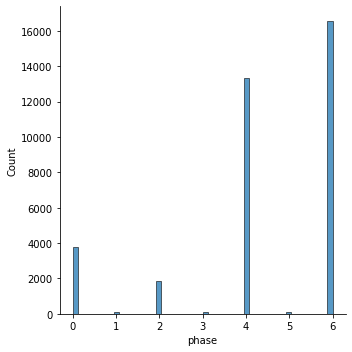

In [ ]:
sns.displot(train, x="phase")

From the result in above diagram we can see that class 6 and 4 dominate the number of class in data. We can call this condition as imbalance data, model can easily understand the class 6 and 4 but will fail to predict for other class. To handle this problem we can do [**Synthetic Minority Oversampling TEchnique (SMOTE)**](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) method, before that we need to transform categorical into numerical value in data using ONE HOT ENCODING (OHE) 

## ONE HOT ENCODING (OHE)
This process will change categorical value into TRUE or FALSE shape data. Why we need this process?. First, SMOTE process cannot be done with categorical value in data. Second, some model cannot handle categorical data, make it into TRUE or FALSE value even better, because model will easily learn TRUE or FALSE value compared to another value type    

In [ ]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 
features_to_encode = ['station','network']
cnt = 0 
#train
for feature in features_to_encode:
    if cnt > 0 :
      res = encode_and_bind(res, feature)
    else:
      res = encode_and_bind(train, feature)
    cnt += 1 
#test
cnt = 0 
for feature in features_to_encode:
    if cnt > 0 :
      res_test = encode_and_bind(res_test, feature)
    else:
      res_test = encode_and_bind(test, feature)
    cnt += 1 

In [ ]:
res

,id,phase,E-1,E-2,E-3,E-4,E-5,E-6,E-7,E-8,...,Z-17,Z-18,Z-19,Z-20,station_AC04,station_AMT,station_AOS,network_C1,network_HP,network_HT
0,0,6,-40.060604,-260.707855,-2295.125732,-5077.934570,-6510.237793,-6507.307617,-6570.841309,-6639.744141,...,5408.335938,7083.473633,8639.500977,9888.334961,0,0,1,0,0,1
1,1,6,-918.338989,-130.808212,-180.710327,-888.181763,-1270.482300,-1396.425903,-1328.800293,-1324.853394,...,415.490448,750.097290,1068.296143,1360.592407,0,0,1,0,0,1
2,2,4,-19588.193359,-22775.435547,-14151.219727,-1106.306152,479.042145,8777.960938,27075.169922,24998.861328,...,-9635.690430,2515.936035,5403.634766,7697.293945,1,0,0,1,0,0
3,3,0,71.364502,102.589439,140.858856,113.558861,72.772079,97.952866,132.099426,98.619576,...,-43.658840,-37.447033,-41.053375,-54.754852,0,0,1,0,0,1
4,4,6,11264.663086,16095.182617,16701.796875,15911.804688,13841.098633,11352.826172,9862.090820,9329.799805,...,178161.437500,185418.484375,191004.015625,193284.250000,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35881,35881,6,7880.614746,8688.561523,8825.509766,8084.964844,6757.714355,5400.477051,4112.736816,2953.214600,...,4446.166016,4281.390625,3773.695312,2911.149658,0,0,1,0,0,1
35882,35882,6,-1862.605469,-1015.105225,-1491.742554,112.670189,458.357025,-548.750671,5934.537109,447.223450,...,-1261.064331,-1045.916626,1086.603638,-1823.545044,0,1,0,0,1,0
35883,35883,6,-4897.524414,-4547.483887,-3450.159668,-2070.732422,-739.391541,1491.856323,4499.432617,6384.674316,...,4317.965820,5215.839355,5016.916016,3708.820557,0,0,1,0,0,1
35884,35884,2,-21840.333984,-21545.867188,1763.364014,63479.605469,107657.640625,97654.109375,24631.556641,-40136.253906,...,65886.500000,165103.140625,146718.015625,-80342.414062,1,0,0,1,0,0


The OHE result can be see in last several data above. TRUE or FALSE value comes in numerical format (1 and 0)   

## Oversampling using SMOTE
 

### Takeout lable from dataframe
Firstly, we need to separate class from data. 

In [ ]:
train_label = res['phase']
train = res.drop('phase', 1)
print(train_label)

0        6
1        6
2        4
3        0
4        6
        ..
35881    6
35882    6
35883    6
35884    2
35885    6
Name: phase, Length: 35886, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
smote = SMOTE()
train, train_label = smote.fit_resample(train, train_label)

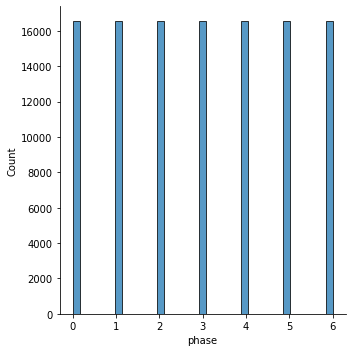

In [ ]:
sns.displot(train_label)

As you can see from above diagram, all 6 classes have the same amount.  

## Checking features distribution 
Why we need to check features distribution?. first, it can show outlier, outlier can be troublesome for our model so it important to find. second, large data distribution can reduce our model performance. 

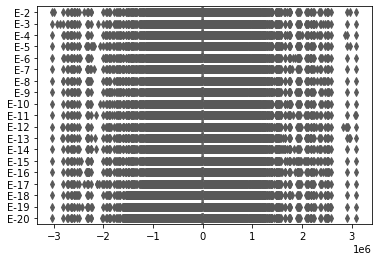

In [ ]:
num_cols = [x for x in train.columns]
cols = num_cols[1:-6]
E = train[cols[1:20]]
N = train[cols[21:40]]
Z = train[cols[41:60]]
ax = sns.boxplot(data=E, orient="h", palette="Set2")

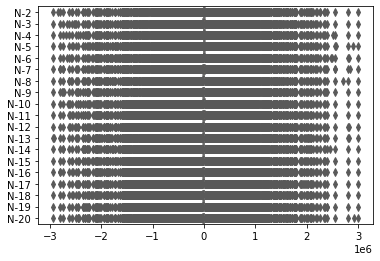

In [ ]:
ax = sns.boxplot(data=N, orient="h", palette="Set2")

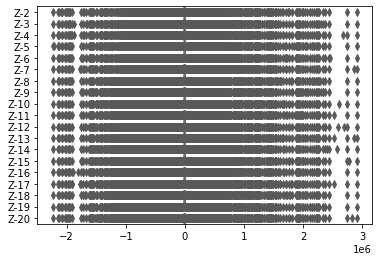

In [ ]:
ax = sns.boxplot(data=Z, orient="h", palette="Set2")

From a several diagram above we can see that each sensor (E,N and Z) have large distribution. In the below right corner of each diagram it show (le6), we can asume it to be less than or equal to 6 digit. Based on those things we need to scaling our data. In this process we gonna use standard scaler, before that we need to split data so each data train and test will have it own range distribution.

### Split Data

In [ ]:
x_train, x_test, y_train, y_test  = train_test_split(train, train_label, random_state=42, test_size=0.1)

## Standard Scaler Process

In [ ]:
st = MaxAbsScaler()
# st = StandardScaler()
x_train.iloc[:, 1:-6] = pd.DataFrame(st.fit_transform(x_train.values[:, 1:-6]), columns=x_train.columns.values[1:-6], index=x_train.index)
x_test.iloc[:, 1:-6] = pd.DataFrame(st.transform(x_test.values[:, 1:-6]), columns=x_test.columns.values[1:-6], index=x_test.index)
res_test.iloc[:, 1:-6] = pd.DataFrame(st.transform(res_test.values[:, 1:-6]), columns=res_test.columns.values[1:-6], index=res_test.index)
x_train

,id,E-1,E-2,E-3,E-4,E-5,E-6,E-7,E-8,E-9,...,Z-17,Z-18,Z-19,Z-20,station_AC04,station_AMT,station_AOS,network_C1,network_HP,network_HT
2513,2513,-0.000540,-0.000679,-0.000806,-0.000903,-0.000879,-0.000834,-0.000778,-0.000712,-6.418802e-04,...,-0.000059,-0.000007,0.000001,-0.000013,0,0,1,0,0,1
80918,16296,0.009123,0.003415,0.001773,-0.001576,-0.003388,-0.013512,-0.027666,-0.028836,-2.547784e-02,...,-0.018567,0.008067,0.003651,-0.038513,1,0,0,1,0,0
46909,17429,-0.000022,-0.000028,-0.000019,-0.000014,-0.000026,-0.000031,-0.000018,-0.000012,-2.471876e-05,...,0.000026,0.000026,0.000030,0.000034,0,0,0,0,0,0
14747,14747,-0.002738,0.003807,-0.000251,-0.008513,-0.017118,-0.019569,-0.008430,0.009357,2.237942e-02,...,-0.009021,0.002147,0.006407,0.003067,1,0,0,1,0,0
39949,6748,0.000003,0.000007,-0.000002,0.000001,0.000006,-0.000002,-0.000003,0.000004,2.483892e-08,...,0.000010,0.000005,0.000013,0.000008,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76820,12316,0.024840,0.019857,0.009713,-0.003784,-0.012948,-0.007792,0.003488,-0.001405,-9.844791e-03,...,0.005575,-0.014914,-0.018675,-0.006684,0,0,1,0,0,1
110268,9896,-0.304863,-0.308178,-0.305642,-0.303427,-0.281654,-0.252690,-0.216025,-0.172913,-1.224077e-01,...,-0.036333,-0.045824,-0.049160,-0.048306,0,1,0,0,1,0
103694,23191,-0.305669,-0.299165,-0.284477,-0.262534,-0.223090,-0.181124,-0.131758,-0.081934,-3.183804e-02,...,-0.048524,-0.048498,-0.042426,-0.032883,0,1,0,0,1,0
860,860,0.000274,0.001008,0.001549,0.001960,0.002285,0.002579,0.002463,0.002050,1.683963e-03,...,0.000338,0.000361,0.000057,-0.000382,0,0,1,0,0,1


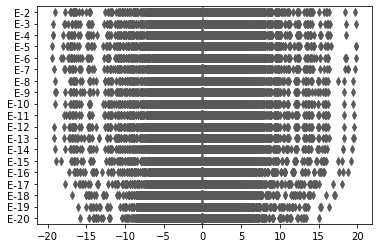

In [ ]:
num_cols = [x for x in x_train.columns]
cols = num_cols[1:-6]
E = x_train[cols[1:20]]
N = x_train[cols[21:40]]
Z = x_train[cols[41:60]]
ax = sns.boxplot(data=E, orient="h", palette="Set2")

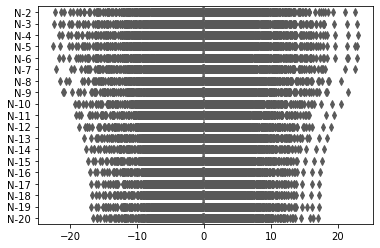

In [ ]:
ax = sns.boxplot(data=N, orient="h", palette="Set2")

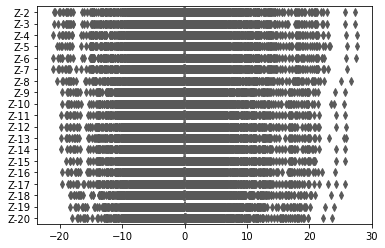

In [ ]:
ax = sns.boxplot(data=Z, orient="h", palette="Set2")

As we can see from several diagram above the distribution range has change drastically into lower distribution data. 

##Modeling
The main thing in this process is to define model and it own paramters and make it learn to our data train, so it can predict our test data

### Define Model

In [ ]:
model = RandomForestClassifier(max_depth=100,min_samples_split=50, random_state=42)
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=50, random_state=42)

### Prediction Result

In [ ]:
predicted = model.predict(x_test)
print(predicted)

[3 4 5 ... 4 3 2]


#### Metrics Result Without Balancing Class


In [ ]:
print(f1_score(y_test, predicted, average="weighted"))
print(classification_report(y_test, predicted))

0.969042053155125
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1660
           1       1.00      1.00      1.00      1682
           2       0.95      0.99      0.97      1647
           3       1.00      1.00      1.00      1635
           4       0.91      0.89      0.90      1679
           5       1.00      1.00      1.00      1572
           6       0.93      0.91      0.92      1719

    accuracy                           0.97     11594
   macro avg       0.97      0.97      0.97     11594
weighted avg       0.97      0.97      0.97     11594



## Submission for kaggle

In [ ]:
frames = [x_train, x_test]

x = pd.concat(frames)
frames = [y_train, y_test]

y = pd.concat(frames)


In [ ]:
model.fit(x, y)

RandomForestClassifier(max_depth=100, min_samples_split=50, random_state=42)

### Takeout Id test

In [ ]:
test_id = res_test['id']
print(test_id)

0            0
1            1
2            2
3            3
4            4
         ...  
23919    23919
23920    23920
23921    23921
23922    23922
23923    23923
Name: id, Length: 23924, dtype: int64


In [ ]:
predicted = model.predict(res_test)
print(predicted)

[6 4 4 ... 4 4 4]


In [ ]:
res = pd.DataFrame(
    {'id':test_id ,
     'phase': predicted
    })
res

,id,phase
0,0,6
1,1,4
2,2,4
3,3,4
4,4,0
...,...,...
23919,23919,4
23920,23920,6
23921,23921,4
23922,23922,4


In [ ]:
res.to_csv('/content/drive/MyDrive/Project/Data/res.csv', index=False)